# Spark Metastore

Let us continue about details related to Spark Metastore.

* Staring Spark Context
* Reading and Processing Tables
* Creating Partitioned Tables
* Creating Temp Views
* Using Spark SQL

## Reading and Processing Tables

Let us see how we can read tables using functions such as `spark.read.table` and process data using Data Frame APIs.

* Using Data Frame APIs - `spark.read.table("table_name")`.
* We can also prefix the database name to read tables belong to a particular database.
* When we read the table, it will result in a Data Frame.
* Once Data Frame is created we can use functions such as `filter` or `where`, `groupBy`, `sort` or `orderBy` to process the data in the Data Frame.

### Tasks
Let us see how we can create a table using data in a file and then read into a Data Frame.

* Create Database for **airlines** data.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.sql(f"CREATE DATABASE IF NOT EXISTS {username}_airlines")

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

* Create table by name **airport-codes** for file **airport-codes.txt**. The file contains header and each field in each row is delimited by a tab character.

In [ ]:
airport_codes_path = f"/user/{username}/airlines_all/airport-codes"

In [ ]:
spark.sql(f'DROP TABLE {username}_airlines.airport_codes')

In [ ]:
airport_codes_df = spark. \
    read. \
    csv(airport_codes_path,
        sep="\t",
        header=True,
        inferSchema=True
       )

In [ ]:
airport_codes_df.write.saveAsTable(f"{username}_airlines.airport_codes")

* Read data from table and get number of airports by state.

In [ ]:
airport_codes = spark.read.table("airport_codes")

In [ ]:
type(airport_codes)

In [ ]:
spark.sql('DESCRIBE FORMATTED airport_codes').show(100, False)

In [ ]:
airport_codes. \
    groupBy("state"). \
    count(). \
    show()

## Creating Partitioned Tables

We can also create partitioned tables as part of Spark Metastore Tables.

* There are some challenges in creating partitioned tables directly using `spark.catalog.createTable`.
* But if the directories are similar to partitioned tables with data, we should be able to create partitioned tables. They are typically external tables.
* Let us create partitioned table for `orders` by `order_month`.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.sql(f'CREATE DATABASE IF NOT EXISTS {username}_retail')

In [ ]:
spark.catalog.setCurrentDatabase(f'{username}_retail')

In [ ]:
orders_path = '/public/retail_db/orders'

In [ ]:
%%sh

hdfs dfs -ls /public/retail_db/orders

In [ ]:
from pyspark.sql.functions import date_format

In [ ]:
spark.sql('DROP TABLE orders_part')

In [ ]:
%%sh

hdfs dfs -ls /user/`whoami`/retail_db/orders_part

In [ ]:
%%sh

hdfs dfs -rm -R /user/`whoami`/retail_db/orders_part

In [ ]:
spark. \
    read. \
    csv(orders_path,
        schema='''order_id INT, order_date DATE,
                  order_customer_id INT, order_status STRING
               '''
       ). \
    withColumn('order_month', date_format('order_date', 'yyyyMM')). \
    write. \
    partitionBy('order_month'). \
    parquet(f'/user/{username}/retail_db/orders_part')

In [ ]:
%%sh

hdfs dfs -ls -R /user/`whoami`/retail_db/orders_part

In [ ]:
spark. \
    read. \
    parquet(f'/user/{username}/retail_db/orders_part/order_month=201308'). \
    show()

In [ ]:
spark. \
    read. \
    parquet(f'/user/{username}/retail_db/orders_part'). \
    show()

In [ ]:
spark. \
    catalog. \
    createTable('orders_part',
                path=f'/user/{username}/retail_db/orders_part',
                source='parquet'
               )

In [ ]:
spark.catalog.recoverPartitions('orders_part')

In [ ]:
spark.read.table('orders_part').show()

In [ ]:
spark.sql('SELECT order_month, count(1) FROM orders_part GROUP BY order_month').show()

## Creating Temp Views

So far we spoke about permanent metastore tables. Now let us understand how to create temporary views using a Data Frame.

* We can create temporary view for a Data Frame using `createTempView` or `createOrReplaceTempView`.
* `createOrReplaceTempView` will replace existing view, if it already exists.
* While tables in Metastore are permanent, views are temporary.
* Once the application exits, temporary views will be deleted or flushed out.

### Tasks

Let us perform few tasks to create temporary view and process the data using the temporary view.

* Create temporary view by name **airport_codes_v** for file **airport-codes.txt**. The file contains header and each field in each row is delimited by a tab character.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

In [ ]:
spark.catalog.listTables()

In [ ]:
airport_codes_path = f"/public/airlines_all/airport-codes"

In [ ]:
airport_codes_df = spark. \
    read. \
    csv(airport_codes_path,
        sep="\t",
        header=True,
        inferSchema=True
       )

In [ ]:
airport_codes_df.createTempView("airport_codes_v")

In [ ]:
spark.catalog.listTables()

* Read data from view and get number of airports by state.

In [ ]:
airport_codes = spark.read.table("airport_codes_v")

In [ ]:
airport_codes. \
    groupBy("state"). \
    count(). \
    show()

* List the tables in the metastore and views.

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

In [ ]:
spark.catalog.listTables()

## Using Spark SQL

Let us understand how we can use Spark SQL to process data in Metastore Tables and Temporary Views.

* Once tables are created in metastore or temporary views are created, we can run queries against the tables to perform all standard transformations.

In [ ]:
import getpass
username = getpass.getuser()

In [ ]:
spark.catalog.setCurrentDatabase(f"{username}_airlines")

* Here are some of the transformations which can be performed.
 * Row Level Transformations using functions in SELECT clause.
 * Filtering using WHERE clause
 * Aggregations using GROUP BY and aggregate functions.
 * Sorting using ORDER BY or SORT BY

### Tasks

Let us perform some tasks to understand how to process data using Spark SQL using Metastore Tables or Temporary Views.
* Make sure table or view created for airport-codes. We can use the table or view created in the previous step.

In [ ]:
spark.catalog.listTables()

* Write a query to get number of airports per state in the US. 
 * Get only those states which have more than 10 airports.
 * Make sure data is sorted in descending order by number of airports.

In [101]:
spark. \
    sql("""SELECT state, count(1) AS airport_cnt
           FROM airport_codes_v
           GROUP BY state
               HAVING count(1) >= 10
           ORDER BY airport_cnt DESC
        """). \
  show()

+-----+-----------+
|state|airport_cnt|
+-----+-----------+
|   CA|         29|
|   TX|         26|
|   AK|         25|
|   BC|         22|
|   NY|         18|
|   ON|         18|
|   MI|         18|
|   FL|         18|
|   MT|         14|
|   PQ|         13|
|   PA|         13|
|   CO|         12|
|   IL|         12|
|   NC|         10|
|   WY|         10|
+-----+-----------+



In [102]:
airport_count = spark. \
    sql("""SELECT state, count(1) AS airport_cnt
           FROM airport_codes_v
           GROUP BY state
               HAVING count(1) >= 10
        """)

In [121]:
from matplotlib import pyplot as plt

airport_count_dict = dict(airport_count.collect())

In [130]:
states = list(airport_count_dict.keys())
states

['BC',
 'NY',
 'MI',
 'NC',
 'IL',
 'ON',
 'TX',
 'CO',
 'PA',
 'AK',
 'PQ',
 'CA',
 'MT',
 'WY',
 'FL']

In [132]:
airport_counts = list(airport_count_dict.values())
airport_counts

[22, 18, 18, 10, 12, 18, 26, 12, 13, 25, 13, 29, 14, 10, 18]

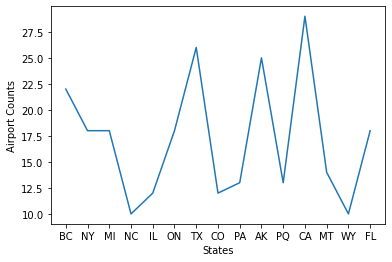

In [134]:
plt.plot(states, airport_counts)
plt.xlabel('States')
plt.ylabel('Airport Counts')
plt.show()